**PROJECT: ANTI-HATER FILTER FOR SOCIAL NETWORKS**

**1. Prerequisites**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPooling1D
from sklearn.metrics import confusion_matrix
from joblib import dump, load
import gdown
from keras.models import load_model
import random
import warnings
warnings.filterwarnings('ignore')

**2. Dataset**

In [17]:
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/Filter_Toxic_Comments_dataset.csv'

df = pd.read_csv(url)

print(df.head())

print(df.info())

                                        comment_text  toxic  severe_toxic  \
0  Explanation\nWhy the edits made under my usern...      0             0   
1  D'aww! He matches this background colour I'm s...      0             0   
2  Hey man, I'm really not trying to edit war. It...      0             0   
3  "\nMore\nI can't make any real suggestions on ...      0             0   
4  You, sir, are my hero. Any chance you remember...      0             0   

   obscene  threat  insult  identity_hate  sum_injurious  
0        0       0       0              0              0  
1        0       0       0              0              0  
2        0       0       0              0              0  
3        0       0       0              0              0  
4        0       0       0              0              0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         ---------

In [18]:
df.shape

(159571, 8)

In [19]:
df.duplicated().sum()

np.int64(0)

In [20]:
df.duplicated(subset=['comment_text']).sum()

np.int64(0)

The dataset consists of 159571 samples and there are no missing data for each of the 8 columns present.

In [21]:
labels_names = df.columns[1:-1]

for label in labels_names:
    example = df[df[label] == 1]['comment_text'].iloc[100]
    print(f'Example for {label}:\n{example}\n')

non_injurious_example = df[df['sum_injurious'] == 0]['comment_text'].iloc[100]
print(f'\nExample for non-injurious comment:\n{non_injurious_example}')

Example for toxic:
"

So Jim Burton, child molesting faggot, I see you are still with us for yet another day, making a total buffoon out of yourself as usual.  I don't know what is sadder here - you, or the extreme hypocritical arrogance you show by lecturing the world about ""ethical principles"" for your claimed ""rights"" to abuse our children.  You have no ethical principles to save your life, but it's exactly as the Roman poet said, isn't it? ""the harlot doth always rebuke the chaste.""  Will you ever drop dead, we might all breathe a little easier for our kids sake. You truly disgust me with every word you write.  "

Example for severe_toxic:
YOU ARE A DICK HEAD!!!!!!

Example for obscene:
Fartsalot56 says f**k you motherclucker!!

Example for threat:
"

""I think we should kill all the jews and homosexuals and handicaped people."", (said Adolf Hitler)."

Example for insult:
well fag... block me. 

block me?! oh the world will shurly end!
come off your high horse.
i'll say what 

In [22]:
sum_inj_counts = df['sum_injurious'].value_counts()
sum_inj_perc = (sum_inj_counts.sort_values(ascending=False)*100)/len(df)
sum_inj_df = pd.DataFrame({'Counts': sum_inj_counts,
                           'Percentages': sum_inj_perc.round(2)})

print('Absolute and Relative Frequencies of sum_injurious')
print(sum_inj_df.sort_values(by=['Counts'], ascending=False))

Absolute and Relative Frequencies of sum_injurious
               Counts  Percentages
sum_injurious                     
0              143346        89.83
1                6360         3.99
3                4209         2.64
2                3480         2.18
4                1760         1.10
5                 385         0.24
6                  31         0.02


The results show that approximately 90% of the comments in the dataset are harmless while the remaining 10% have at least one label equal to 1. This is therefore a highly unbalanced dataset and this aspect should be carefully evaluated.

In [23]:
non_inj_comments = df[df['sum_injurious'] == 0]
inj_comments = df[df['sum_injurious'] > 0]
perc_non_inj_comments = len(non_inj_comments)*100/len(df)
perc_inj_comments = len(inj_comments)*100/len(df)

print(f'Non-injurious comments: {len(non_inj_comments)}'
      f' ({round(perc_non_inj_comments, 2)} %)')
print(f'Injurious comments: {len(inj_comments)}'
      f' ({round(perc_inj_comments, 2)} %)')

Non-injurious comments: 143346 (89.83 %)
Injurious comments: 16225 (10.17 %)


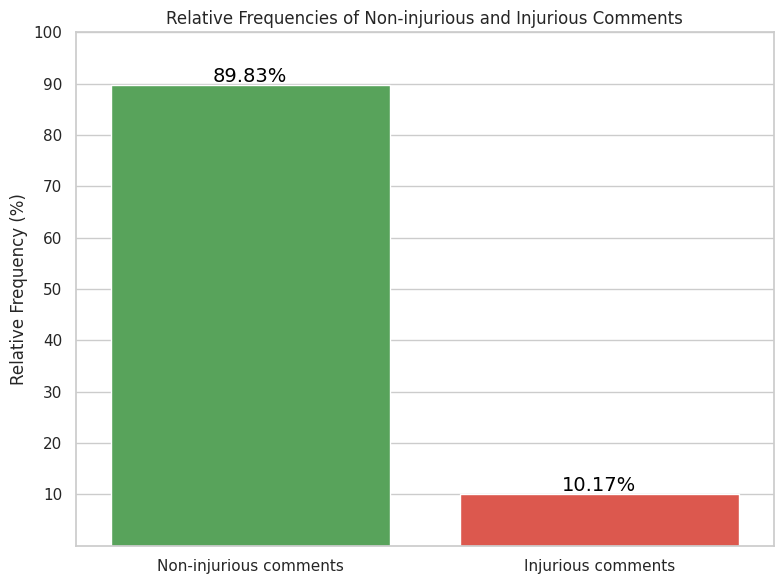

In [24]:
sns.set_theme(style="whitegrid")

custom_palette = ['#4CAF50', '#F44336']

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=['Non-injurious comments', 'Injurious comments'],
    y=[perc_non_inj_comments, perc_inj_comments],
    palette=custom_palette,
    legend=False
)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points',
                color='black',
                fontsize=14)

plt.title('Relative Frequencies of Non-injurious and Injurious Comments')
plt.ylabel('Relative Frequency (%)')
plt.yticks(range(10, 110, 10))
plt.tight_layout()
plt.show()

It has been observed that the vast majority of comments in the dataset are harmless, and consequently, it can be deduced that the labels are unbalanced, being equal to 0 in at least 90% of cases.

In [25]:
labels_names = df.columns[1:-1]

labels_counts = df[labels_names].sum()
labels_perc = (labels_counts/len(inj_comments))*100
labels_df = pd.DataFrame({'Counts': labels_counts,
                          'Percentages': labels_perc.round(2)})

print('Absolute and Relative Frequencies of Judgments')
print(labels_df.sort_values(by=['Counts'], ascending=False))

Absolute and Relative Frequencies of Judgments
               Counts  Percentages
toxic           15294        94.26
obscene          8449        52.07
insult           7877        48.55
severe_toxic     1595         9.83
identity_hate    1405         8.66
threat            478         2.95


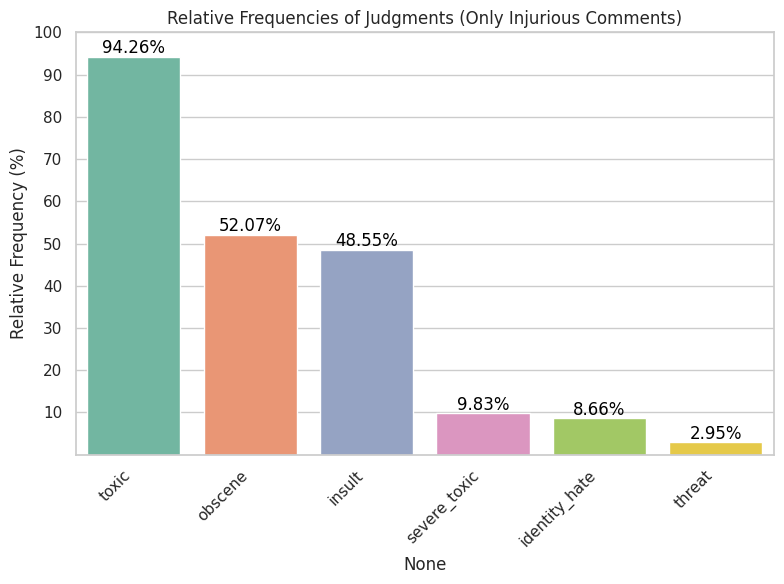

In [27]:
labels_df_sorted = labels_df.sort_values(by=['Counts'], ascending=False)

custom_palette = sns.color_palette("Set2", n_colors=len(labels_df_sorted))

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x=labels_df_sorted.index,
    y=labels_df_sorted['Percentages'],
    palette=custom_palette,
    legend=False
)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points',
                color='black',
                fontsize=12)

plt.title('Relative Frequencies of Judgments (Only Injurious Comments)')
plt.ylabel('Relative Frequency (%)')
plt.yticks(range(10, 110, 10))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

It is also noted that the different labels are unbalanced. The harmful comments are almost entirely made up of the rating "toxic"
(94.26%), and in about half of the cases, the ratings "obscene"
(52.07%) and "insult"
(48.55%). The ratings "severe_toxic"
and "identity_hate"
are present at 9.83% and 8.66%, respectively, and finally the rating "threat"
is present in only 2.95% of the harmful comments.

               toxic  severe_toxic  obscene  threat  insult  identity_hate
toxic          15294          1595     7926     449    7344           1302
severe_toxic    1595          1595     1517     112    1371            313
obscene         7926          1517     8449     301    6155           1032
threat           449           112      301     478     307             98
insult          7344          1371     6155     307    7877           1160
identity_hate   1302           313     1032      98    1160           1405


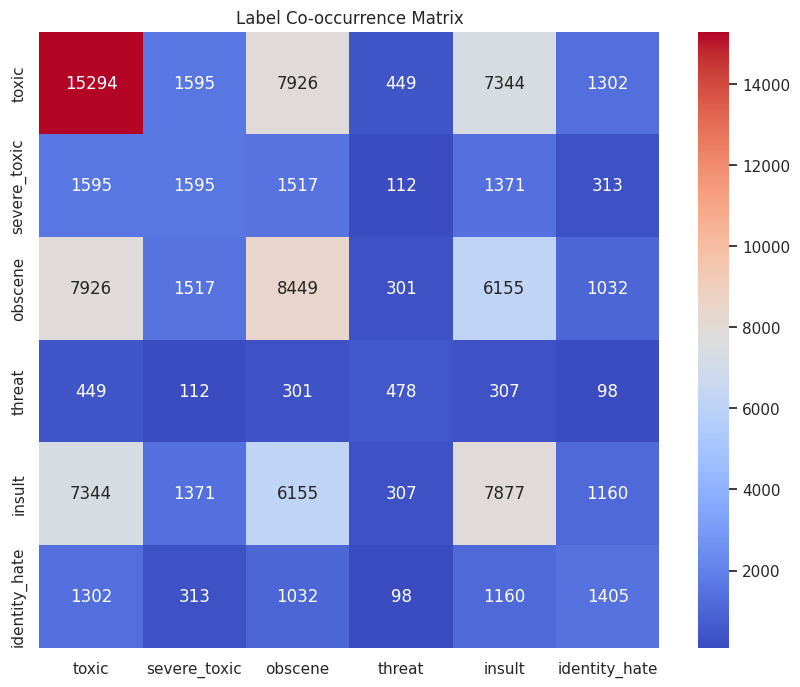

In [28]:
label_cooccurrence_matrix = df[labels_names].T.dot(df[labels_names])
print(label_cooccurrence_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(label_cooccurrence_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.title('Label Co-occurrence Matrix')
plt.show()

From the resulting co-occurrence matrix, the following considerations can be deduced:
the toxic rating, as seen previously, is assigned in 94.26% of the harmful comments, and in fact, it appears to be almost always present
simultaneously with all the other ratings.
The severe_toxic rating is specifically always present simultaneously with the toxic rating. This makes perfect sense, given that a
severely toxic rating will certainly also be toxic. Furthermore, severe_toxic is also often present simultaneously with the insult rating.
The obscene rating is often present simultaneously with the insult rating and vice versa.
The threat rating, which is the least present, is often simultaneous with the obscene and insult ratings, and is almost entirely present simultaneously with the
toxic rating.
The identity_hate rating is often present together with the obscene and insult ratings.


**3. Data Preparation and Visualization**

In [30]:
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def text_cleaner(sentence):

    '''
    Cleans and preprocesses a given text sentence.

    This function performs the following operations:
    1. Converts the text to lowercase.
    2. Removes punctuation by replacing it with spaces.
    3. Removes digits.
    4. Filters out stopwords from the text.
    5. Lemmatizes the remaining words.
    6. Removes extra whitespace from the text.

    Parameters:
    - sentence (str): The input text sentence to be cleaned and preprocessed.

    Returns:
    - str: The cleaned and preprocessed text sentence.
    '''

    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]', ' ', sentence)
    sentence = re.sub(r'\d+', '', sentence)
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords])
    sentence = ' '.join([lemmatizer.lemmatize(word) for word in sentence.split()])
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [31]:
df['comment_text'] = df['comment_text'].apply(text_cleaner)
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0
1,aww match background colour seemingly stuck th...,0,0,0,0,0,0,0
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0
3,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0
4,sir hero chance remember page,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,second time asking view completely contradicts...,0,0,0,0,0,0,0
159567,ashamed horrible thing put talk page,0,0,0,0,0,0,0
159568,spitzer umm there actual article prostitution ...,0,0,0,0,0,0,0
159569,look like actually put speedy first version de...,0,0,0,0,0,0,0


In [32]:
X = df['comment_text'].values

y = df[['toxic',
        'severe_toxic',
        'obscene',
        'threat',
        'insult',
        'identity_hate']].values

print('Text array X')
print(X, X.shape)

print('\nLabels array y')
print(y, y.shape)

Text array X
['explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired'
 'aww match background colour seemingly stuck thanks talk january utc'
 'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info'
 ... 'spitzer umm there actual article prostitution ring crunch captain'
 'look like actually put speedy first version deleted look'
 'really think understand came idea bad right away kind community go bad idea go away instead helping rewrite'] (159571,)

Labels array y
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] (159571, 6)


**4. Train-Test**

In [33]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X,
                                                            y,
                                                            test_size=0.3,
                                                            random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                y_val_test,
                                                test_size=1/3,
                                                random_state=1)

print(f'Train set shape: {X_train.shape} {y_train.shape}')
print(f'Validation set shape: {X_val.shape} {y_val.shape}')
print(f'Test set shape: {X_test.shape} {y_test.shape}')

Train set shape: (111699,) (111699, 6)
Validation set shape: (31914,) (31914, 6)
Test set shape: (15958,) (15958, 6)


In [34]:
train_labels_counts = pd.DataFrame(y_train, columns=labels_names).sum()
train_labels_perc = (train_labels_counts/len(y_train))*100
train_labels_df = pd.DataFrame({'Counts': train_labels_counts,
                                'Percentages': train_labels_perc.round(2)})
print('Absolute and Relative Frequencies of Train Set Labels:')
print(train_labels_df)

val_labels_counts = pd.DataFrame(y_val, columns=labels_names).sum()
val_labels_perc = (val_labels_counts/len(y_val))*100
val_labels_df = pd.DataFrame({'Counts': val_labels_counts,
                              'Percentages': val_labels_perc.round(2)})
print('\nAbsolute and Relative Frequencies of Validation Set Labels:')
print(val_labels_df)

test_label_counts = pd.DataFrame(y_test, columns=labels_names).sum()
test_label_perc = (test_label_counts/len(y_test))*100
test_label_df = pd.DataFrame({'Counts': test_label_counts,
                              'Percentages': test_label_perc.round(2)})
print('\nAbsolute and Relative Frequencies of Test Set Labels:')
print(test_label_df)

Absolute and Relative Frequencies of Train Set Labels:
               Counts  Percentages
toxic           10599         9.49
severe_toxic     1104         0.99
obscene          5905         5.29
threat            324         0.29
insult           5490         4.91
identity_hate     963         0.86

Absolute and Relative Frequencies of Validation Set Labels:
               Counts  Percentages
toxic            3145         9.85
severe_toxic      333         1.04
obscene          1718         5.38
threat            106         0.33
insult           1609         5.04
identity_hate     321         1.01

Absolute and Relative Frequencies of Test Set Labels:
               Counts  Percentages
toxic            1550         9.71
severe_toxic      158         0.99
obscene           826         5.18
threat             48         0.30
insult            778         4.88
identity_hate     121         0.76


Before evaluating the performance of models consisting of recurrent layers, it is useful to start with a baseline
logistic regression model.

In [35]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f'X_train_tfidf shape: {X_train_tfidf.shape}')
print(f'X_val_tfidf shape: {X_val_tfidf.shape}')
print(f'X_test_ifidf shape: {X_test_tfidf.shape}')

X_train_tfidf shape: (111699, 10000)
X_val_tfidf shape: (31914, 10000)
X_test_ifidf shape: (15958, 10000)


Once the text has been vectorized, the OneVsRestClassifier can be used for multilabel classification by specifying
a logistic regression as the estimator argument.

In [36]:
lr = LogisticRegression(solver='liblinear', random_state=1)
clf = OneVsRestClassifier(lr)

clf.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(random_state=1,
                                                 solver='liblinear'))

In [37]:
y_pred_train = clf.predict(X_train_tfidf)
y_pred_test = clf.predict(X_test_tfidf)

In [38]:
def print_classification_reports(model_name,
                                 y_pred_train,
                                 y_pred_test,
                                 y_train=y_train,
                                 y_test=y_test):

    '''
    Prints classification reports for both training and test sets.

    Parameters:
    - model_name (str): Name of the model.
    - y_pred_train (array-like): Predicted labels for the training set.
    - y_pred_test (array-like): Predicted labels for the test set.
    - y_train (array-like, optional): True labels for the training set.
      Default is 'y_train'.
    - y_test (array-like, optional): True labels for the test set.
      Default is 'y_test'.

    Returns:
    - None: Prints classification reports with precision, recall, and F1-score.
    '''

    print(f'{model_name} - Classification Report - Train Set')
    print(classification_report(y_train,
                                y_pred_train,
                                target_names=labels_names,
                                zero_division=1))

    print(f'\n{model_name} - Classification Report - Test Set')
    print(classification_report(y_test,
                                y_pred_test,
                                target_names=labels_names,
                                zero_division=1))

In [39]:
print_classification_reports(model_name='Logistic Regression',
                             y_pred_train=y_pred_train,
                             y_pred_test=y_pred_test)

Logistic Regression - Classification Report - Train Set
               precision    recall  f1-score   support

        toxic       0.94      0.64      0.76     10599
 severe_toxic       0.63      0.27      0.38      1104
      obscene       0.93      0.67      0.78      5905
       threat       0.68      0.11      0.19       324
       insult       0.85      0.56      0.68      5490
identity_hate       0.76      0.21      0.33       963

    micro avg       0.90      0.59      0.71     24385
    macro avg       0.80      0.41      0.52     24385
 weighted avg       0.89      0.59      0.70     24385
  samples avg       0.99      0.95      0.95     24385


Logistic Regression - Classification Report - Test Set
               precision    recall  f1-score   support

        toxic       0.92      0.60      0.73      1550
 severe_toxic       0.45      0.22      0.29       158
      obscene       0.90      0.65      0.76       826
       threat       0.60      0.06      0.11        48
    

Looking at the classification reports, we can first note the absence of significant overfitting.
The most important metric to consider for this multilabel classification problem with unbalanced labels is undoubtedly the
F1-score which represents the harmonic mean between precision and recall. A high value ensures that performance is balanced between the two metrics, severely penalizing situations in which one of the two values is low.


To go further, you can use the class_weight="balanced" parameter as an argument to the
LogisticRegression classifier. This parameter balances the labels by applying weights inversely proportional to the
frequencies of their classes 0 and 1. Therefore, the OneVsRestClassifier will build a binary classifier for each label with the
balanced classes.

In [40]:
penalties = ['l1', 'l2']
c_values = [0.01, 0.1, 1, 10, 100]

f1_scores_val = {}

for penalty in penalties:
    for C in c_values:
        lr = LogisticRegression(solver='liblinear',
                                class_weight='balanced',
                                penalty=penalty,
                                C=C,
                                random_state=1)
        clf = OneVsRestClassifier(lr)
        clf.fit(X_train_tfidf, y_train)

        y_pred_val = clf.predict(X_val_tfidf)
        f1_macro_val = f1_score(y_val, y_pred_val, average='macro')

        f1_scores_val[(penalty, C)] = f1_macro_val

best_penalty_c = max(f1_scores_val, key=f1_scores_val.get)
best_f1 = f1_scores_val[best_penalty_c]

print(f'Best penalty and C: {best_penalty_c}')
print(f'Validation set F1-score: {best_f1:.4f}')

Best penalty and C: ('l2', 10)
Validation set F1-score: 0.5553


In [41]:
lr = LogisticRegression(solver='liblinear',
                        class_weight='balanced',
                        penalty='l2',
                        C=10,
                        random_state=1)
clf = OneVsRestClassifier(lr)

clf.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced',
                                                 random_state=1,
                                                 solver='liblinear'))

In [42]:
y_pred_train = clf.predict(X_train_tfidf)
y_pred_test = clf.predict(X_test_tfidf)

print_classification_reports(
    model_name="Logistic Regression + class_weight='balanced'",
    y_pred_train=y_pred_train,
    y_pred_test=y_pred_test)

Logistic Regression + class_weight='balanced' - Classification Report - Train Set
               precision    recall  f1-score   support

        toxic       0.69      0.97      0.81     10599
 severe_toxic       0.37      1.00      0.54      1104
      obscene       0.74      0.99      0.85      5905
       threat       0.48      1.00      0.65       324
       insult       0.62      0.99      0.76      5490
identity_hate       0.35      1.00      0.52       963

    micro avg       0.63      0.98      0.77     24385
    macro avg       0.54      0.99      0.69     24385
 weighted avg       0.66      0.98      0.78     24385
  samples avg       0.94      1.00      0.94     24385


Logistic Regression + class_weight='balanced' - Classification Report - Test Set
               precision    recall  f1-score   support

        toxic       0.61      0.84      0.71      1550
 severe_toxic       0.26      0.73      0.38       158
      obscene       0.63      0.87      0.73       826
       

After evaluating the baseline logistic regression model, we can move on to evaluating the effectiveness of deep learning models consisting of recurrent layers.

In [43]:
vocabulary_size = 10000
tokenizer = Tokenizer(num_words=vocabulary_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

print(f'Vocabulary size: {vocabulary_size}')
print(f'Size of word_index: {len(tokenizer.word_index)}')
print(f'First five word_index: {list(tokenizer.word_index.items())[:5]}')

Vocabulary size: 10000
Size of word_index: 132229
First five word_index: [('<OOV>', 1), ('article', 2), ('page', 3), ('wikipedia', 4), ('talk', 5)]


In [44]:
train_sequences= tokenizer.texts_to_sequences(X_train)
val_sequences= tokenizer.texts_to_sequences(X_val)
test_sequences= tokenizer.texts_to_sequences(X_test)

print(f'First sequence of train sequences: {train_sequences[0]}')
print(f'First sequence of validation sequences: {val_sequences[0]}')
print(f'First sequence of test sequences: {test_sequences[0]}')

First sequence of train sequences: [340, 3348, 278, 4344, 328, 340, 3348, 4, 3348, 1359, 188, 99]
First sequence of validation sequences: [35, 945, 2642, 1200, 381, 8, 1, 4015, 180, 1018, 2753, 467, 83, 67, 4015]
First sequence of test sequences: [32, 1371, 1, 6650, 356, 824, 939, 4213, 3, 1101, 355, 1820, 139, 125, 565, 7929, 19, 63, 756, 2653, 3, 12, 58, 208, 285, 82, 565, 209, 756, 16, 127, 8377, 1818, 658, 684, 84, 340, 2, 23, 65, 115, 1, 75]


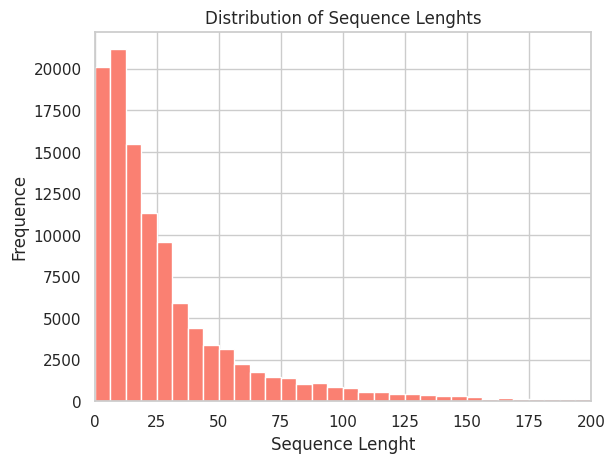


Mean lenght of sequences: 34.69
Median lenght of sequences: 18.0
Max lenght of sequences: 1250


In [47]:
sequence_lengths = [len(seq) for seq in train_sequences]

plt.hist(sequence_lengths, bins=200, color='salmon')
plt.xlabel('Sequence Lenght')
plt.ylabel('Frequence')
plt.title('Distribution of Sequence Lenghts')
plt.xlim(0, 200)
plt.show()

print(f'\nMean lenght of sequences: {np.mean(sequence_lengths):.2f}')
print(f'Median lenght of sequences: {np.median(sequence_lengths)}')
print(f'Max lenght of sequences: {max(sequence_lengths)}')

The resulting sequences are of different lengths, so the sequences will need to be filled with zeros or "truncated" to ensure that they all have the same length. This is necessary because the deep learning model requires fixed-length inputs.

In [48]:
maxlen = int(np.percentile(sequence_lengths, 90))
print(f"maxlen: {maxlen}")

maxlen: 77


In [49]:
padded_train_sequences = pad_sequences(train_sequences,
                                       maxlen=maxlen,
                                       padding='post',
                                       truncating='post')
padded_val_sequences = pad_sequences(val_sequences,
                                     maxlen=maxlen,
                                     padding='post',
                                     truncating='post')
padded_test_sequences = pad_sequences(test_sequences,
                                      maxlen=maxlen,
                                      padding='post',
                                      truncating='post')

print(f'Shape of padded train sequences: {padded_train_sequences.shape}')
print(f'Shape of padded validation sequences: {padded_val_sequences.shape}')
print(f'Shape of padded test sequences: {padded_test_sequences.shape}')

print(f'\nFirst sequence of padded train sequences: {padded_train_sequences[0]}')
print(f'First sequence of padded validation sequences: {padded_val_sequences[0]}')
print(f'First sequence of padded test sequences: {padded_test_sequences[0]}')

Shape of padded train sequences: (111699, 77)
Shape of padded validation sequences: (31914, 77)
Shape of padded test sequences: (15958, 77)

First sequence of padded train sequences: [ 340 3348  278 4344  328  340 3348    4 3348 1359  188   99    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
First sequence of padded validation sequences: [  35  945 2642 1200  381    8    1 4015  180 1018 2753  467   83   67
 4015    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   

**5. Neural Model Types**

The following neural recurrent network models can be created and evaluated using Keras: 1. LSTM Model, 2. Bidirectional LSTM Model and 3. Convolutional Bidirectional LSTM Model.

In [50]:
num_samples = y_train.shape[0]
class_counts = np.sum(y_train, axis=0)
class_weights = num_samples/class_counts
class_weights = class_weights/np.sum(class_weights)

print(f'Class weights for each label:\n{np.round(class_weights, 2)}')

Class weights for each label:
[0.02 0.17 0.03 0.56 0.03 0.19]


In [51]:
def weighted_binary_crossentropy(weights=class_weights):

    '''
    Returns a weighted binary cross-entropy loss function.

    Parameters:
    - weights (array-like, optional): Class weights for adjusting the loss.
      Default is 'class_weights'.

    Returns:
    - loss (function): A function that computes the weighted binary-crossentropy
      between the true labels ('y_true') and the predicted labels ('y_pred').
    '''

    def loss(y_true, y_pred):

        '''
        Computes the weighted binary cross-entropy loss.

        Parameters:
        - y_true (tensor): Ground truth binary labels.
        - y_pred (tensor): Predicted probabilities for the positive class.

        Returns:
        - Tensor: The mean weighted binary cross-entropy loss.
        '''

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        weighted_bce = bce * weights

        return tf.reduce_mean(weighted_bce)

    return loss

In [52]:
def compile_model(model, learning_rate=1e-3):

    '''
    Compiles a model with weighted binary cross-entropy loss and F1 metrics.

    Parameters:
    - model (tf.keras.Model): The model to be compiled.
    - learning_rate (float, optional): Learning rate for the Adam optimizer.
      Default is 1e-3.

    Returns:
    - None: The function compiles the model in-place with the specified
      optimizer, loss, and metrics.
    '''

    f1_scores = [F1Score(name='f1_macro', average='macro', threshold=0.5),
                 F1Score(name='f1_weighted', average='weighted', threshold=0.5)]

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=weighted_binary_crossentropy(),
                  metrics=f1_scores)

In [53]:
def train_model(model,
                batch_size,
                epochs,
                early_stopping=None,
                padded_train_sequences=padded_train_sequences,
                y_train=y_train,
                padded_val_sequences=padded_val_sequences,
                y_val=y_val):

    '''
    Trains the model with specified training and validation data.

    Parameters:
    - model (tf.keras.Model): The model to be trained.
    - batch_size (int): Number of samples per gradient update.
    - epochs (int): Number of epochs to train the model.
    - early_stopping (tf.keras.callbacks.EarlyStopping, optional):
      Callback to stop training when a monitored metric has stopped improving.
      Default is None.
    - padded_train_sequences (array-like, optional): Padded input sequences
      for training. Default is 'padded_train_sequences'.
    - y_train (array-like, optional): Ground truth labels for training.
      Default is 'y_train'.
    - padded_val_sequences (array-like, optional): Padded input sequences
      for validation. Default is 'padded_val_sequences'.
    - y_val (array-like, optional): Ground truth labels for validation.
      Default is 'y_val'.

    Returns:
    - history (tf.keras.callbacks.History): Training history containing loss
      and metrics recorded during training.
    '''

    if early_stopping is None:
        early_stopping = EarlyStopping(monitor='val_f1_macro',
                                       mode='max',
                                       patience=3,
                                       restore_best_weights=True,
                                       verbose=1)

    history = model.fit(padded_train_sequences,
                        y_train,
                        validation_data=(padded_val_sequences, y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[early_stopping],
                        verbose=1)

    return history

In [54]:
def plot_learning_curve(history, metric='f1_macro'):

    """
    Plots the learning curve for a specified metric.

    Parameters:
    - history (tf.keras.callbacks.History): History object containing training
      metrics recorded during model training.
    - metric (str, optional): The metric to plot. Default is 'f1_macro'.

    Returns:
    - None: Displays the learning curve plot for training and validation metrics.
    """

    epochs = range(1, len(history.history[metric]) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history[metric], label='train')
    plt.plot(epochs, history.history['val_' + metric], label='validation')
    plt.title(f'{metric.capitalize()} Score')
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

The first neural network model built is the
LSTM Model. The network is created with the Keras sequential model, which allows the following layers to be added one after the other:
the first layer,
input, specifies the input size as
(maxlen), meaning that each input example is a sequence of length 77.
The second layer, the
embedding
layer, has an input size equal to the
vocabulary_size
(10000), and the embedding size is set to 128. This layer therefore transforms each token in the sequence into a dense 128-dimensional vector, useful for representing the meaning of words in a compact way.
The third layer is an
LSTM
(Long Short-Term Memory) with 128 units. The
activation
and
recurrent_activation
are the default: hyperbolic tangent and sigmoid, respectively. This recurrent layer stores significant information and discards parts of the text that do not contribute to the target task. The output of this layer will be a compact representation of the sequence.
The fourth layer is a
dropout layer
which is used to prevent overfitting during model training. It sets a dropout rate of 50%, meaning that half of the neurons in the previous layer are ignored at each training iteration.
Finally, there is the
Dense
(fully-connected) layer consisting of 6 neurons. This layer uses the sigmoid activation function to perform the binary classification for each of the 6 labels (resulting in a probability between 0 and 1).

In [55]:
clear_session()

LSTM_model = Sequential(name='LSTM_model')
LSTM_model.add(Input(shape=(maxlen,)))
LSTM_model.add(Embedding(input_dim=vocabulary_size, output_dim=128))
LSTM_model.add(LSTM(units=128))
LSTM_model.add(Dropout(rate=0.5))
LSTM_model.add(Dense(units=6, activation='sigmoid'))

compile_model(LSTM_model)

LSTM_model.summary()

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 77, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,412,358 (5.39 MB)

 Trainable params: 1,412,358 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history_LSTM = train_model(LSTM_model,
                           batch_size=32,
                           epochs=20)

val_f1_scores_LSTM = LSTM_model.evaluate(padded_val_sequences, y_val, verbose=0)

print(f'\nValidation F1-score macro LSTM: {val_f1_scores_LSTM[1]:.4f}')
print(f'Validation F1-score weighted LSTM: {val_f1_scores_LSTM[2]:.4f}')

Epoch 1/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 630s 180ms/step - f1_macro: 0.0140 - f1_weighted: 0.0221 - loss: 0.0094 - val_f1_macro: 0.3359 - val_f1_weighted: 0.5986 - val_loss: 0.0050
Epoch 2/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 675s 178ms/step - f1_macro: 0.3520 - f1_weighted: 0.6198 - loss: 0.0045 - val_f1_macro: 0.3774 - val_f1_weighted: 0.6510 - val_loss: 0.0042
Epoch 3/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 620s 177ms/step - f1_macro: 0.3997 - f1_weighted: 0.6689 - loss: 0.0038 - val_f1_macro: 0.3989 - val_f1_weighted: 0.6683 - val_loss: 0.0040
Epoch 4/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 620s 177ms/step - f1_macro: 0.4395 - f1_weighted: 0.6928 - loss: 0.0033 - val_f1_macro: 0.4348 - val_f1_weighted: 0.6791 - val_loss: 0.0041
Epoch 5/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 645s 183ms/step - f1_macro: 0.5387 - f1_weighted: 0.7248 - loss: 0.0027 - val_f1_macro: 0.4772 - val_f1_weighted: 0.6826 - val_loss: 0.0042
Epoch 6/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 663s 178ms/step - f1_macro: 0.6442 - f1_weighted

Early stopping was activated at epoch 10, so the best performance on the validation set's macro F1-score was achieved at the end of
epoch 7.

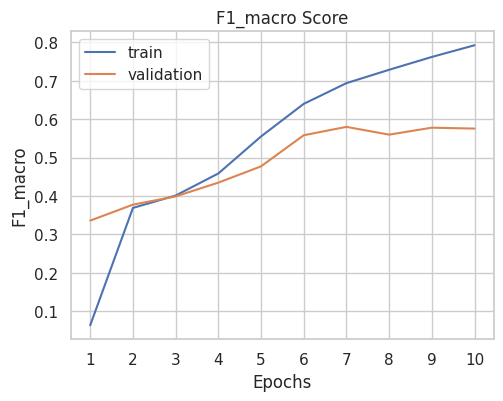

In [58]:
learning_curve_LSTM = plot_learning_curve(history_LSTM)

In [59]:
test_f1_scores_LSTM = LSTM_model.evaluate(padded_test_sequences, y_test, verbose=0)

print(f'Test F1-score macro LSTM: {test_f1_scores_LSTM[1]:.4f}')
print(f'Test F1-score weighted LSTM: {test_f1_scores_LSTM[2]:.4f}')

Test F1-score macro LSTM: 0.5088
Test F1-score weighted LSTM: 0.6956


In [60]:
y_pred_train_LSTM = (LSTM_model.predict(padded_train_sequences, verbose=0) > 0.5)
y_pred_test_LSTM = (LSTM_model.predict(padded_test_sequences, verbose=0) > 0.5)

print_classification_reports(model_name='LSTM',
                             y_pred_train=y_pred_train_LSTM,
                             y_pred_test=y_pred_test_LSTM)

LSTM - Classification Report - Train Set
               precision    recall  f1-score   support

        toxic       0.88      0.79      0.83     10599
 severe_toxic       0.68      0.44      0.53      1104
      obscene       0.83      0.89      0.86      5905
       threat       0.82      0.90      0.86       324
       insult       0.76      0.75      0.75      5490
identity_hate       0.86      0.48      0.61       963

    micro avg       0.83      0.78      0.80     24385
    macro avg       0.81      0.71      0.74     24385
 weighted avg       0.83      0.78      0.80     24385
  samples avg       0.98      0.97      0.96     24385


LSTM - Classification Report - Test Set
               precision    recall  f1-score   support

        toxic       0.80      0.73      0.76      1550
 severe_toxic       0.36      0.25      0.29       158
      obscene       0.74      0.80      0.77       826
       threat       0.32      0.25      0.28        48
       insult       0.66      0.64

Analyzing the metrics individually, we observe an improvement in the F1 on each label compared to logistic regression.

The second model being evaluated is the
Bidirectional LSTM Model. This model's architecture is identical to that of the previous one, with the only difference being the recurrent layer, which is no longer a simple
LSTM
but a
Bidirectional LSTM.

In [61]:
clear_session()

BiLSTM = Sequential(name='BiLSTM')
BiLSTM.add(Input(shape=(maxlen,)))
BiLSTM.add(Embedding(input_dim=vocabulary_size, output_dim=128))
BiLSTM.add(Bidirectional(LSTM(units=128)))
BiLSTM.add(Dropout(rate=0.5))
BiLSTM.add(Dense(units=6, activation='sigmoid'))

compile_model(BiLSTM)

BiLSTM.summary()

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 77, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,544,710 (5.89 MB)

 Trainable params: 1,544,710 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history_BiLSTM = train_model(BiLSTM,
                             batch_size=32,
                             epochs=20)

val_f1_scores_BiLSTM = BiLSTM.evaluate(padded_val_sequences, y_val, verbose=0)

print(f'\nValidation F1-score macro BiLSTM: {val_f1_scores_BiLSTM[1]:.4f}')
print(f'Validation F1-score weighted BiLSTM: {val_f1_scores_BiLSTM[2]:.4f}')

Epoch 1/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1064s 303ms/step - f1_macro: 0.2276 - f1_weighted: 0.3765 - loss: 0.0078 - val_f1_macro: 0.4198 - val_f1_weighted: 0.6800 - val_loss: 0.0041
Epoch 2/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1099s 303ms/step - f1_macro: 0.4441 - f1_weighted: 0.6875 - loss: 0.0037 - val_f1_macro: 0.5061 - val_f1_weighted: 0.7072 - val_loss: 0.0037
Epoch 3/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1122s 308ms/step - f1_macro: 0.5511 - f1_weighted: 0.7186 - loss: 0.0030 - val_f1_macro: 0.6065 - val_f1_weighted: 0.7315 - val_loss: 0.0035
Epoch 4/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1113s 311ms/step - f1_macro: 0.6415 - f1_weighted: 0.7475 - loss: 0.0026 - val_f1_macro: 0.5579 - val_f1_weighted: 0.7076 - val_loss: 0.0036
Epoch 5/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1129s 319ms/step - f1_macro: 0.7082 - f1_weighted: 0.7691 - loss: 0.0021 - val_f1_macro: 0.6061 - val_f1_weighted: 0.7310 - val_loss: 0.0039
Epoch 6/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1157s 318ms/step - f1_macro: 0.7408 - f1_we

Early stopping was activated at epoch 6, so the best performance on the validation set's macro F1-score was achieved at the end of
epoch 3.

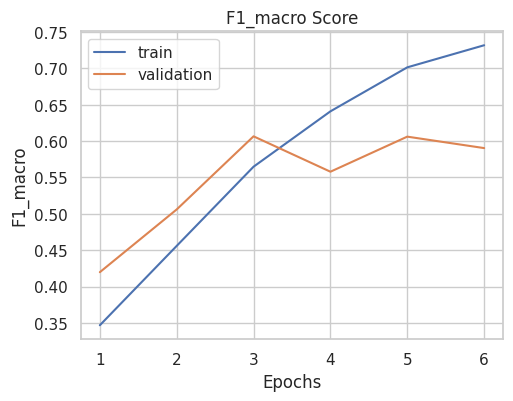

In [63]:
learning_curve_BiLSTM = plot_learning_curve(history_BiLSTM)

In [64]:
test_f1_scores_BiLSTM = BiLSTM.evaluate(padded_test_sequences, y_test, verbose=0)

print(f'Test F1-score macro BiLSTM: {test_f1_scores_BiLSTM[1]:.4f}')
print(f'Test F1-score weighted BiLSTM: {test_f1_scores_BiLSTM[2]:.4f}')

Test F1-score macro BiLSTM: 0.5780
Test F1-score weighted BiLSTM: 0.7267


The metrics obtained are lower than those obtained on the validation set.

In [65]:
y_pred_train_BiLSTM = (BiLSTM.predict(padded_train_sequences, verbose=0) > 0.5)
y_pred_test_BiLSTM = (BiLSTM.predict(padded_test_sequences, verbose=0) > 0.5)

print_classification_reports(model_name="Bidirectional LSTM",
                             y_pred_train=y_pred_train_BiLSTM,
                             y_pred_test=y_pred_test_BiLSTM)

Bidirectional LSTM - Classification Report - Train Set
               precision    recall  f1-score   support

        toxic       0.86      0.75      0.80     10599
 severe_toxic       0.60      0.47      0.53      1104
      obscene       0.87      0.80      0.83      5905
       threat       0.78      0.71      0.74       324
       insult       0.75      0.69      0.72      5490
identity_hate       0.75      0.44      0.55       963

    micro avg       0.82      0.72      0.77     24385
    macro avg       0.77      0.64      0.70     24385
 weighted avg       0.82      0.72      0.77     24385
  samples avg       0.98      0.96      0.95     24385


Bidirectional LSTM - Classification Report - Test Set
               precision    recall  f1-score   support

        toxic       0.83      0.73      0.78      1550
 severe_toxic       0.44      0.37      0.40       158
      obscene       0.82      0.78      0.80       826
       threat       0.48      0.29      0.36        48
      

Analyzing the metrics individually, we observe an improvement on the F1 on each label compared to the LSTM.

The last model to be evaluated is the
Convolutional Bidirectional LSTM Model
. This model is a mixed neural network that combines convolution and LSTM.

In [66]:
clear_session()

ConvBiLSTM = Sequential(name='ConvBiLSTM')
ConvBiLSTM.add(Input(shape=(maxlen,)))
ConvBiLSTM.add(Embedding(input_dim=vocabulary_size, output_dim=128))
ConvBiLSTM.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
ConvBiLSTM.add(MaxPooling1D(pool_size=2))
ConvBiLSTM.add(Bidirectional(LSTM(units=128)))
ConvBiLSTM.add(Dropout(rate=0.5))
ConvBiLSTM.add(Dense(units=6, activation='sigmoid'))

compile_model(ConvBiLSTM)

ConvBiLSTM.summary()

Model: "ConvBiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 77, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 73, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 36, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,758 (6.21 MB)

 Trainable params: 1,626,758 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
history_ConvBiLSTM = train_model(ConvBiLSTM,
                                 batch_size=32,
                                 epochs=20)

val_f1_scores_ConvBiLSTM = ConvBiLSTM.evaluate(padded_val_sequences, y_val, verbose=0)

print(f'\nValidation F1-score macro LSTM: {val_f1_scores_ConvBiLSTM[1]:.4f}')
print(f'Validation F1-score weighted LSTM: {val_f1_scores_ConvBiLSTM[2]:.4f}')

Epoch 1/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 728s 207ms/step - f1_macro: 0.2366 - f1_weighted: 0.3971 - loss: 0.0074 - val_f1_macro: 0.3928 - val_f1_weighted: 0.6642 - val_loss: 0.0043
Epoch 2/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 675s 188ms/step - f1_macro: 0.4170 - f1_weighted: 0.6822 - loss: 0.0038 - val_f1_macro: 0.4637 - val_f1_weighted: 0.6640 - val_loss: 0.0040
Epoch 3/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 685s 189ms/step - f1_macro: 0.5178 - f1_weighted: 0.7165 - loss: 0.0031 - val_f1_macro: 0.4858 - val_f1_weighted: 0.6938 - val_loss: 0.0041
Epoch 4/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 654s 187ms/step - f1_macro: 0.6274 - f1_weighted: 0.7523 - loss: 0.0023 - val_f1_macro: 0.5904 - val_f1_weighted: 0.7209 - val_loss: 0.0041
Epoch 5/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 674s 185ms/step - f1_macro: 0.7299 - f1_weighted: 0.7855 - loss: 0.0020 - val_f1_macro: 0.5679 - val_f1_weighted: 0.7172 - val_loss: 0.0046
Epoch 6/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 677s 184ms/step - f1_macro: 0.7869 - f1_weighted

Early stopping was activated at epoch 10, so the best performance on the validation set's macro F1-score was achieved at the end of
epoch 7.

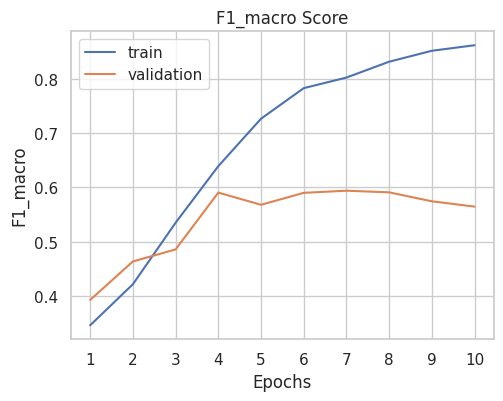

In [68]:
learning_curve_ConvBiLSTM = plot_learning_curve(history_ConvBiLSTM)

In [69]:
test_f1_scores_ConvBiLSTM = ConvBiLSTM.evaluate(padded_test_sequences, y_test, verbose=0)

print(f'Test F1-score macro ConvBiLSTM: {test_f1_scores_ConvBiLSTM[1]:.4f}')
print(f'Test F1-score weighted ConvBiLSTM: {test_f1_scores_ConvBiLSTM[2]:.4f}')

Test F1-score macro ConvBiLSTM: 0.5474
Test F1-score weighted ConvBiLSTM: 0.6996


In [70]:
y_pred_train_ConvBiLSTM = (ConvBiLSTM.predict(padded_train_sequences, verbose=0) > 0.5)
y_pred_test_ConvBiLSTM = (ConvBiLSTM.predict(padded_test_sequences, verbose=0) > 0.5)

print_classification_reports(model_name="Convolutional Bidirectional LSTM",
                             y_pred_train=y_pred_train_ConvBiLSTM,
                             y_pred_test=y_pred_test_ConvBiLSTM)

Convolutional Bidirectional LSTM - Classification Report - Train Set
               precision    recall  f1-score   support

        toxic       0.86      0.89      0.88     10599
 severe_toxic       0.78      0.79      0.79      1104
      obscene       0.80      0.94      0.86      5905
       threat       0.95      0.94      0.95       324
       insult       0.70      0.91      0.79      5490
identity_hate       0.83      0.92      0.87       963

    micro avg       0.80      0.90      0.85     24385
    macro avg       0.82      0.90      0.86     24385
 weighted avg       0.81      0.90      0.85     24385
  samples avg       0.98      0.99      0.97     24385


Convolutional Bidirectional LSTM - Classification Report - Test Set
               precision    recall  f1-score   support

        toxic       0.73      0.79      0.76      1550
 severe_toxic       0.38      0.37      0.37       158
      obscene       0.68      0.83      0.75       826
       threat       0.39      0.2

**6. Choosing the best model**

In [71]:
print('F1-SCORE MACRO AND WEIGHTED OF MODELS')

test_f1_macro_lr = f1_score(y_test, y_pred_test, average='macro')
test_f1_weighted_lr = f1_score(y_test, y_pred_test, average='weighted')
print(f'\nTest F1-score macro Logistic Regression: {test_f1_macro_lr:.4f}')
print(f'Test F1-score weighted Logistic Regression: {test_f1_weighted_lr:.4f}')

print(f'\nTest F1-score macro LSTM: {test_f1_scores_LSTM[1]:.4f}')
print(f'Test F1-score weighted LSTM: {test_f1_scores_LSTM[2]:.4f}')

print(f'\nTest F1-score macro BiLSTM: {test_f1_scores_BiLSTM[1]:.4f}')
print(f'Test F1-score weighted BiLSTM: {test_f1_scores_BiLSTM[2]:.4f}')

print(f'\nTest F1-score macro ConvBiLSTM: {test_f1_scores_ConvBiLSTM[1]:.4f}')
print(f'Test F1-score weighted ConvBiLSTM: {test_f1_scores_ConvBiLSTM[2]:.4f}')

F1-SCORE MACRO AND WEIGHTED OF MODELS

Test F1-score macro Logistic Regression: 0.5118
Test F1-score weighted Logistic Regression: 0.6608

Test F1-score macro LSTM: 0.5088
Test F1-score weighted LSTM: 0.6956

Test F1-score macro BiLSTM: 0.5780
Test F1-score weighted BiLSTM: 0.7267

Test F1-score macro ConvBiLSTM: 0.5474
Test F1-score weighted ConvBiLSTM: 0.6996


All three deep learning models tested were able to improve the performance of the baseline logistic regression model as expected. The "best" of these three models can be considered the
Bidirectional LSTM Model, which achieved a macro F1-score of 58% and a weighted F1-score of 73%.

In [72]:
print_classification_reports(model_name="Bidirectional LSTM",
                             y_pred_train=y_pred_train_BiLSTM,
                             y_pred_test=y_pred_test_BiLSTM)

Bidirectional LSTM - Classification Report - Train Set
               precision    recall  f1-score   support

        toxic       0.86      0.75      0.80     10599
 severe_toxic       0.60      0.47      0.53      1104
      obscene       0.87      0.80      0.83      5905
       threat       0.78      0.71      0.74       324
       insult       0.75      0.69      0.72      5490
identity_hate       0.75      0.44      0.55       963

    micro avg       0.82      0.72      0.77     24385
    macro avg       0.77      0.64      0.70     24385
 weighted avg       0.82      0.72      0.77     24385
  samples avg       0.98      0.96      0.95     24385


Bidirectional LSTM - Classification Report - Test Set
               precision    recall  f1-score   support

        toxic       0.83      0.73      0.78      1550
 severe_toxic       0.44      0.37      0.40       158
      obscene       0.82      0.78      0.80       826
       threat       0.48      0.29      0.36        48
      

The improvements obtained compared to the baseline model are significant both for the most frequent labels (toxic, obscene, and
insult) and the less frequent labels (severe_toxic, threat, and identity_hate). Nevertheless, the model's overall performance is not
entirely satisfactory, having achieved "average" results on weighted metrics but "medium-low"
on macro metrics. Indeed, a problem remains in using this model due to the
presence of significant overfitting, which
has not been convincingly reduced despite various models and techniques.

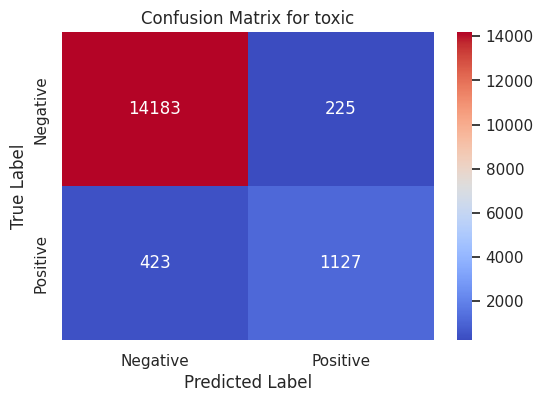

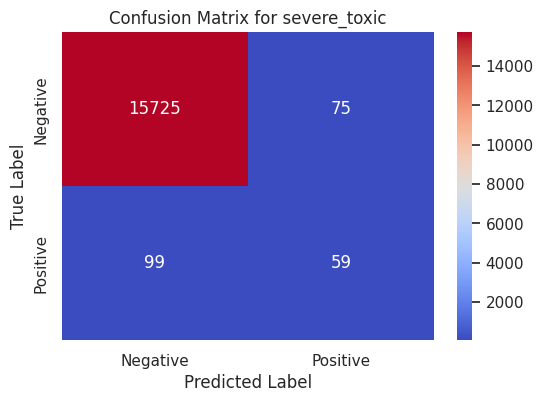

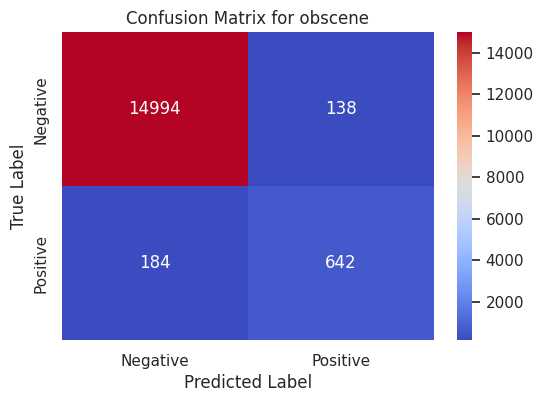

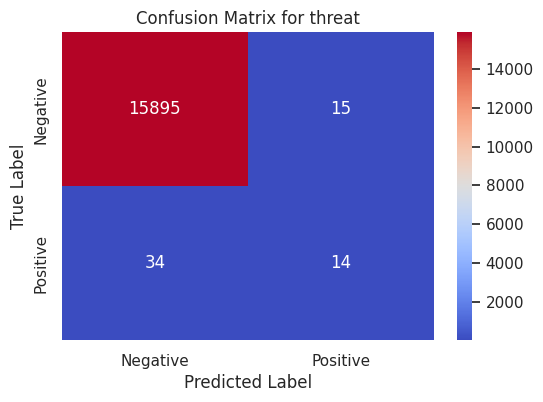

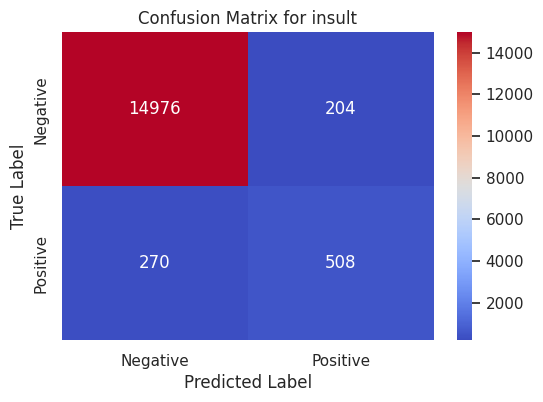

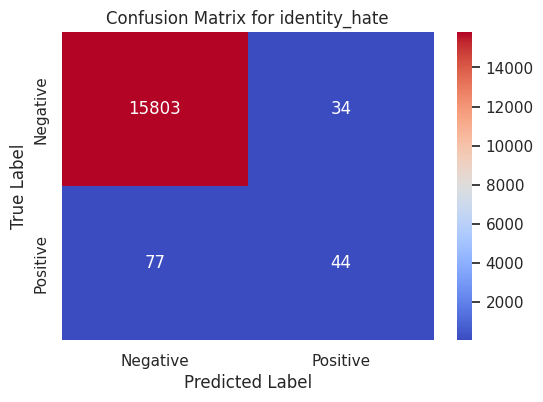

In [73]:
def plot_confusion_matrix_for_each_label(y_true, y_pred, labels_names):

    for i, label_name in enumerate(labels_names):
        y_true_label = y_true[:, i]
        y_pred_label = y_pred[:, i]

        cm = confusion_matrix(y_true_label, y_pred_label)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix for {label_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

plot_confusion_matrix_for_each_label(y_test, y_pred_test_BiLSTM, labels_names)

**7. Model**

In [86]:
import os
from joblib import dump

base_path = '/content/drive/MyDrive/Project Anti-Hater Filter/'

os.makedirs(base_path, exist_ok=True)

tokenizer_path = base_path + 'tokenizer.joblib'
model_path = base_path + 'BiLSTM.keras'

dump(tokenizer, tokenizer_path)
BiLSTM.save(model_path, include_optimizer=False)

print("✅ File salvati nella cartella Google Drive con successo.")

✅ File salvati nella cartella Google Drive con successo.


In [87]:
!pip install gdown --quiet

import gdown
from joblib import load
from tensorflow.keras.models import load_model
import os
import shutil
from google.colab import drive

tokenizer_url = 'https://drive.google.com/uc?id=1mNsNig8UO9xfZX1_6n_cKMy1Ac8y4O_d'
model_url = 'https://drive.google.com/uc?id=1L_YfsnPshNJ4SjTKm8bL_z2tcN4l51ks'

gdown.download(tokenizer_url, 'tokenizer.joblib', quiet=False)
gdown.download(model_url, 'BiLSTM.keras', quiet=False)

drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Project Anti-Hater Filter/'
os.makedirs(base_path, exist_ok=True)

shutil.move('tokenizer.joblib', base_path + 'tokenizer.joblib')
shutil.move('BiLSTM.keras', base_path + 'BiLSTM.keras')

tokenizer = load(base_path + 'tokenizer.joblib')
BiLSTM = load_model(base_path + 'BiLSTM.keras', compile=False)

def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

compile_model(BiLSTM)

print("Tokenizer caricato:", tokenizer)
print("Modello caricato:")
BiLSTM.summary()

Downloading...
From: https://drive.google.com/uc?id=1mNsNig8UO9xfZX1_6n_cKMy1Ac8y4O_d
To: /content/tokenizer.joblib
100%|██████████| 5.83M/5.83M [00:00<00:00, 202MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L_YfsnPshNJ4SjTKm8bL_z2tcN4l51ks
To: /content/BiLSTM.keras
100%|██████████| 6.21M/6.21M [00:00<00:00, 182MB/s]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tokenizer caricato: <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7fe98ff93950>
Modello caricato:


Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 77, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,544,710 (5.89 MB)

 Trainable params: 1,544,710 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

We created a prototype anti-hater filter for social networks by combining all the previous text cleansing,
tokenization, transformation into "paddate" sequences, and model prediction operations into a single function: toxic_comments_filter.

In [83]:
def toxic_comments_filter(sentence):

    '''
    Filters toxic comments using a trained Bidirectional LSTM model.

    Parameters:
    - sentence (str): The input sentence to be analyzed for toxicity.

    Returns:
    - y_pred (array-like): A binary array indicating the presence of toxicity
      in the input sentence (1 for toxic, 0 for non-toxic).
    '''

    cleaned_sentence = text_cleaner(sentence)
    sequence = tokenizer.texts_to_sequences([cleaned_sentence])
    padded_sequence = pad_sequences(sequence,
                                    maxlen=77,
                                    padding='post',
                                    truncating='post')

    y_pred = (BiLSTM.predict(padded_sequence, verbose=0) > 0.5).astype(int)

    return y_pred

In [85]:
valid_indices = [i for i in range(len(y_test)) if np.any(y_test[i] == 1)]

num_sentences = 5
random_indices = random.sample(valid_indices, min(num_sentences, len(valid_indices)))

print(f'Labels names:\n{labels_names}\n')

for index in random_indices:
    sentence = X_test[index]
    predicted_labels = toxic_comments_filter(sentence)
    true_labels = y_test[index]
    print(f'Sentence: {sentence}')
    print(f'Predicted labels: {predicted_labels}')
    print(f'True labels: {true_labels}')
    print('-'*33)

Labels names:
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

Sentence: fucking jew jew wine wine wine want money power hide fucking jew gold act poor get money pussy feel bad poor people
Predicted labels: [[1 1 1 0 1 1]]
True labels: [1 1 1 0 1 1]
---------------------------------
Sentence: extremely fabulous delared ultimate authority thing believe therefore totally rule wikipedia fabulous creature jeff g sure decided within second posting know much anyone else must final word many word kind behavior jeff g word spring immediately mind butthead smartass bully creep sure others suffice epress current state mind thwarted simple attempt express facist nazi etc
Predicted labels: [[0 0 0 0 0 0]]
True labels: [1 0 0 0 1 0]
---------------------------------
Sentence: stop annoying fag one people butt head bother people wish would
Predicted labels: [[1 0 0 0 0 0]]
True labels: [1 0 1 0 1 0]
---------------------------------
Sente

The toxic_comments_filter function works correctly, returning for each sentence the vector containing the six predictions (0/1) for each label.